In [58]:
import numpy as np
import pandas as pd
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor   # 集成算法
from sklearn.model_selection import cross_val_score    # 交叉验证
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score  
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [90]:
df2 = pd.read_excel('data.xlsx','Sheet1',index_col=None,header=0,skiprows=None)
df1= df2.drop('City', 1)#去除省份、地级市名称列，只保留待分析数据
df=df1.dropna(axis=0, how='any', inplace=False) #去除为空值的数据
df.columns=['Province', 'medical', 'fever_clinics', 'cure',
       'death', 'cure_rate', 'death_rate']
#print(df_confirm.shape)

In [67]:
df.describe()

,medical,fever_clinics,cure,death,cure_rate,death_rate
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,4.895833,27.723214,23.122024,0.267857,0.611586,0.008151
std,5.379717,37.321406,40.870746,0.760779,0.269982,0.031953
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.750000,3.000000,0.000000,0.500000,0.000000
50%,3.000000,19.000000,9.000000,0.000000,0.638342,0.000000
75%,8.000000,32.000000,24.000000,0.000000,0.800000,0.000000
max,42.000000,273.000000,335.000000,6.000000,1.000000,0.333333


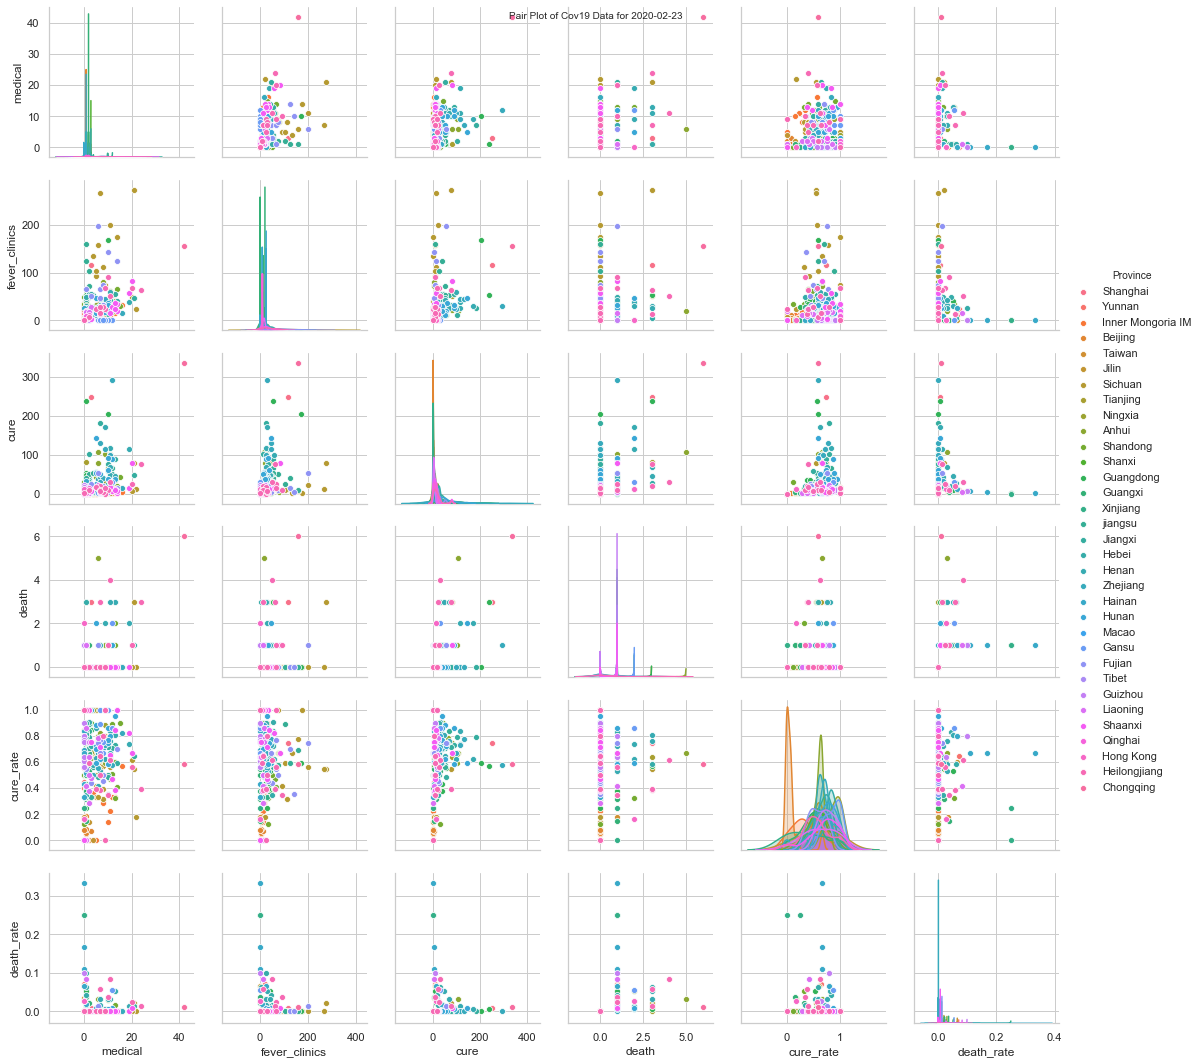

In [91]:
# 可视化数据关系
sns.set(style='whitegrid', context='notebook')   #style控制默认样式,context控制着默认的画幅大小
sns.pairplot(df, hue = 'Province',diag_kind='kde')
plt.suptitle('Pair Plot of Cov19 Data for 2020-02-23',size = 10)
plt.savefig('x.png')

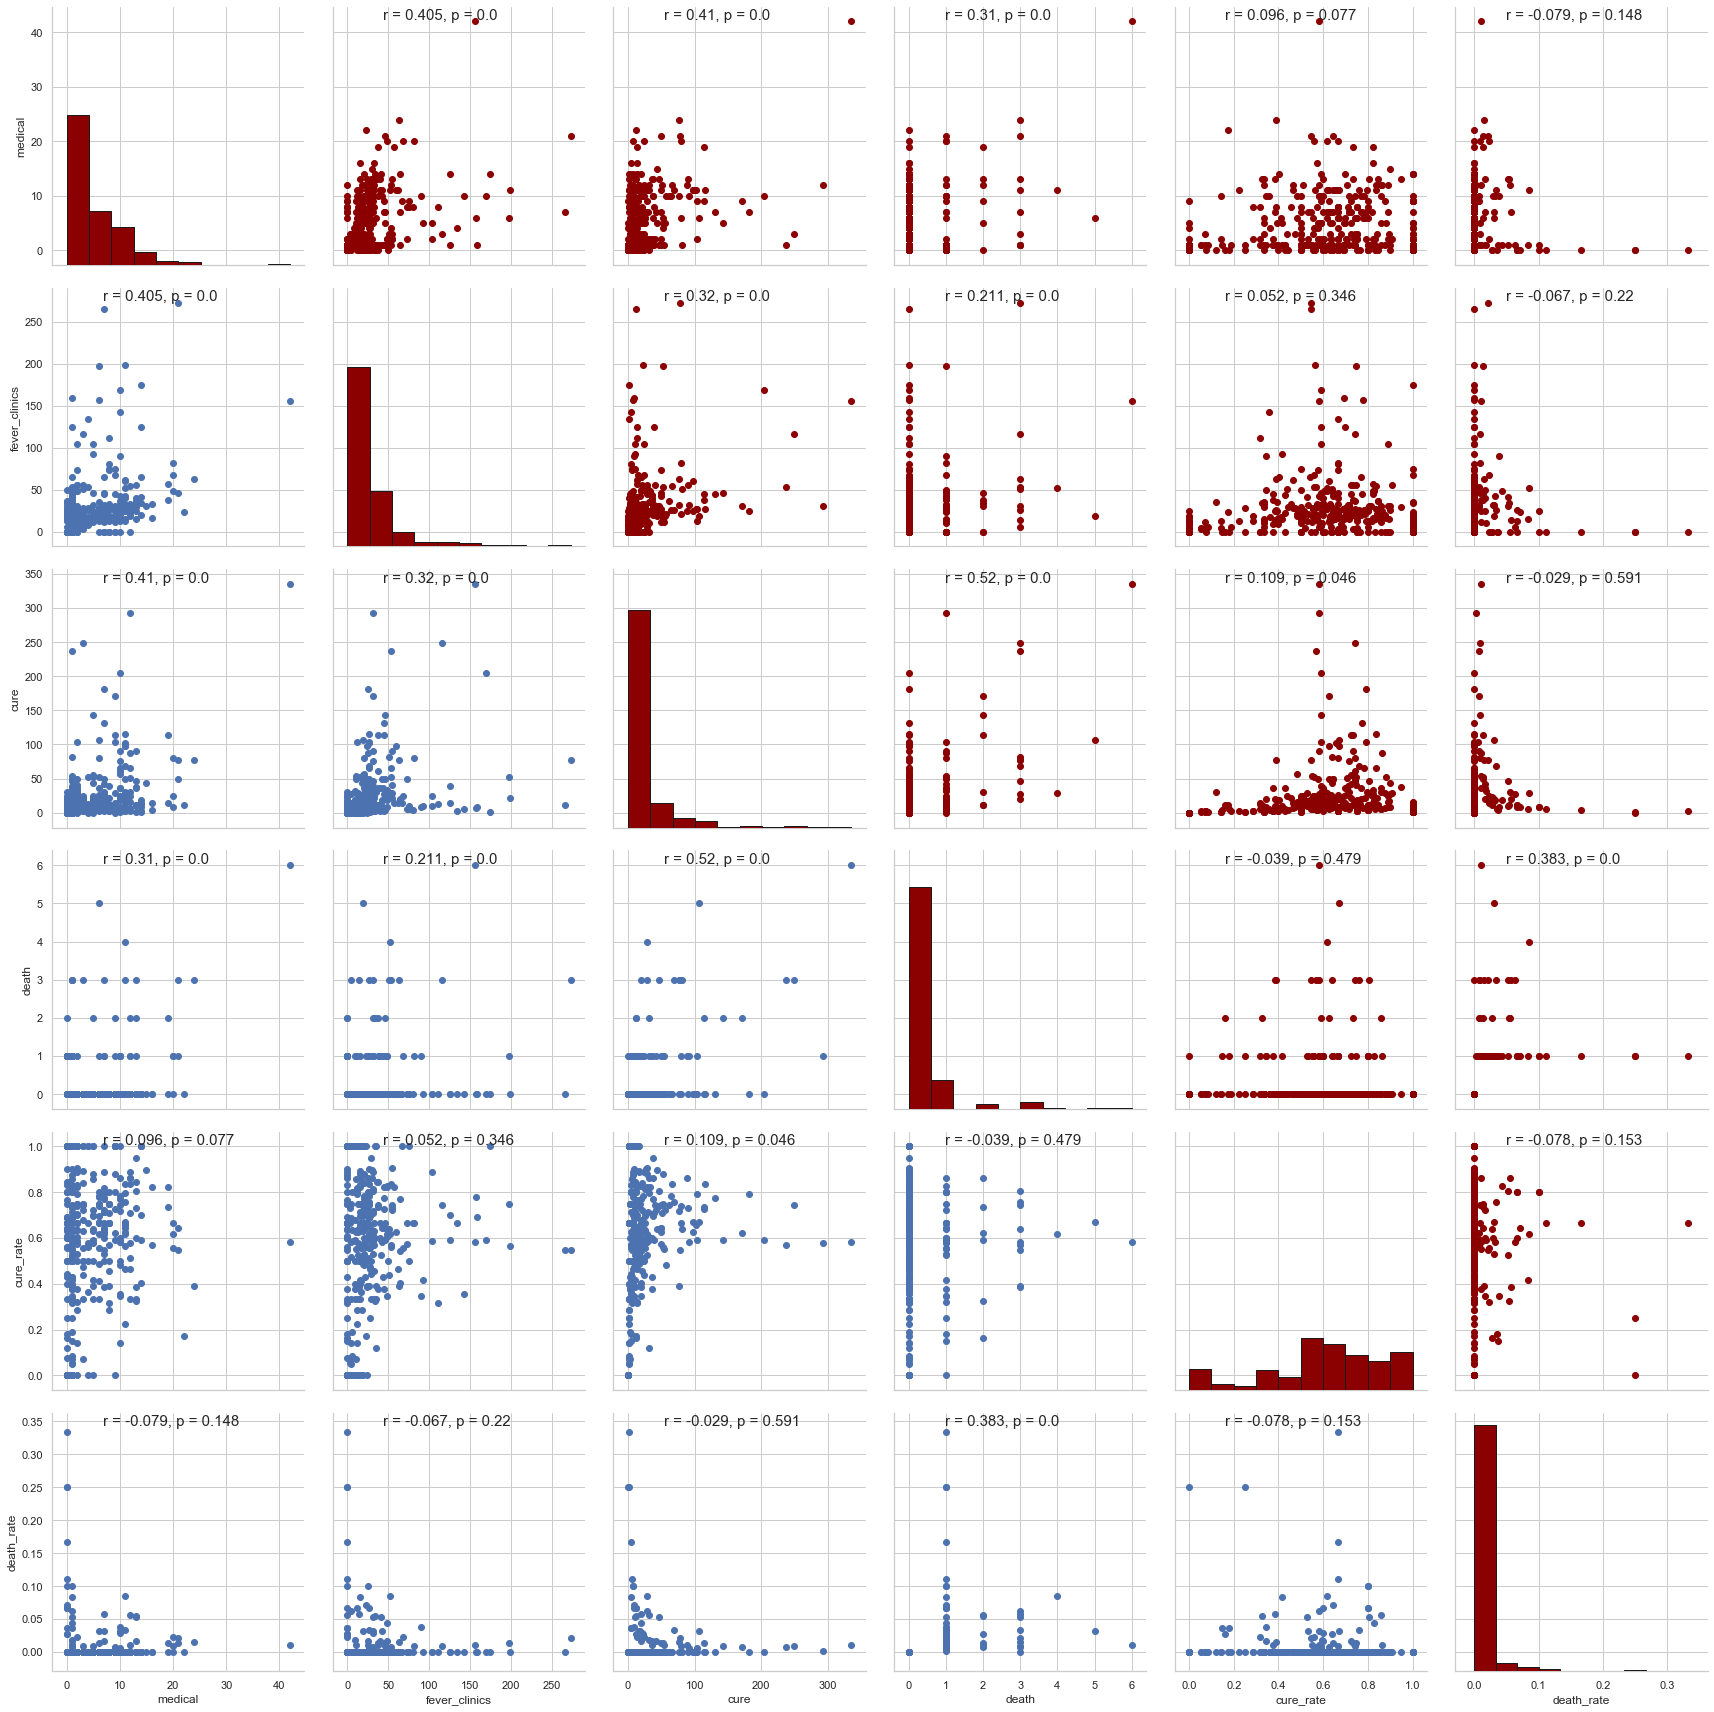

In [112]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y ,**kwargs):

    # Calculate the value
    r,p = stats.pearsonr(x, y)

    # Make the label
    label = 'r = ' + str(round(r, 3))+', p = ' + str(round(p, 3))

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 15, xycoords = ax.transAxes)

# Create a pair grid instance
grid = sns.PairGrid(data= df,vars = ['medical', 'fever_clinics', 'cure','death', 'cure_rate', 'death_rate'], size = 4)

# Map the plots to the locations
grid = grid.map_upper(plt.scatter,color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(plt.scatter)
grid = grid.map_lower(corr)
grid = grid.map_diag(plt.hist, bins = 10,edgecolor =  'k', color = 'darkred');
plt.savefig('t1.png')

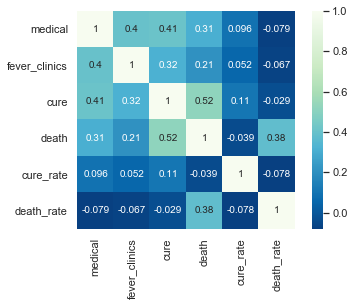

In [76]:
# 相关度
corr = df.corr()
# 相关度热力图
ax = sns.heatmap(corr,cmap='GnBu_r', square=True,annot=True) 
ax.set_ylim(6.0, 0)
plt.savefig('xx.png')

,medical,fever_clinics,cure,death,cure_rate,death_rate
medical,1.000000,0.404832,0.409955,0.310248,0.096465,-0.079128
fever_clinics,0.404832,1.000000,0.320408,0.210887,0.051607,-0.067017
cure,0.409955,0.320408,1.000000,0.520049,0.108996,-0.029397
death,0.310248,0.210887,0.520049,1.000000,-0.038708,0.382995
cure_rate,0.096465,0.051607,0.108996,-0.038708,1.000000,-0.078191
death_rate,-0.079128,-0.067017,-0.029397,0.382995,-0.078191,1.000000


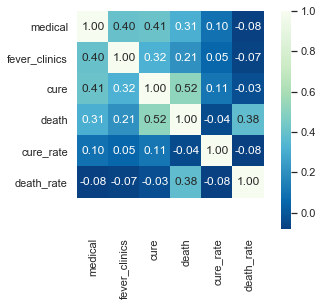

In [105]:
#显著性分析
df= df.drop('Province', 1)
names = df.columns

r=np.array(np.eye(len(names)))
p=np.array(np.eye(len(names)))


for i in range(0, len(names)):  #左闭右开
    for j in range(0, len(names)):
        r0,p0 = stats.pearsonr(df[names[i]],df[names[j]])
        r[i][j]=r0
        p[i][j]=p0

r      =pd.DataFrame(data=r, index=names, columns=names, dtype=float, copy=False)
p_value=pd.DataFrame(data=p, index=names, columns=names, dtype=float, copy=False)


#相关性热力图
ax = sns.heatmap(r,cmap='GnBu_r', square=True,fmt='.2f',annot=True) 
ax.set_ylim(7.0, 0)
plt.savefig('r.png')
r


,medical,fever_clinics,cure,death,cure_rate,death_rate
medical,0.000000e+00,1.107167e-14,4.741318e-15,6.257416e-09,0.077437,1.478134e-01
fever_clinics,1.107167e-14,0.000000e+00,1.849766e-09,9.815219e-05,0.345646,2.204852e-01
cure,4.741318e-15,1.849766e-09,0.000000e+00,1.122953e-24,0.045886,5.912913e-01
death,6.257416e-09,9.815219e-05,1.122953e-24,0.000000e+00,0.479477,3.503912e-13
cure_rate,7.743698e-02,3.456462e-01,4.588555e-02,4.794766e-01,0.000000,1.526852e-01
death_rate,1.478134e-01,2.204852e-01,5.912913e-01,3.503912e-13,0.152685,0.000000e+00


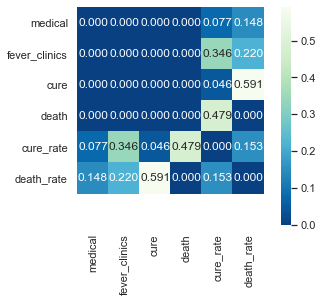

In [106]:
# 显著性p值热力图
ax = sns.heatmap(p_value,cmap='GnBu_r', square=True,fmt='.3f',annot=True) 
ax.set_ylim(7.0, 0)
plt.savefig('xz.png')
p_value

In [107]:
# 自变量
X = df[['medical', 'fever_clinics']].values
# 因变量
y = df[df.columns[2]].values

# 设置交叉验证次数
n_folds = 5

# 建立贝叶斯岭回归模型
br_model = BayesianRidge()

# 普通线性回归
lr_model = LinearRegression()

# 弹性网络回归模型
etc_model = ElasticNet()

# 支持向量机回归
svr_model = SVR()

# 梯度增强回归模型对象
gbr_model = GradientBoostingRegressor()

# 不同模型的名称列表
model_names = ['BayesianRidge', 'LinearRegression', 'ElasticNet', 'SVR', 'GBR']
# 不同回归模型
model_dic = [br_model, lr_model, etc_model, svr_model, gbr_model]
# 交叉验证结果
cv_score_list = []
# 各个回归模型预测的y值列表
pre_y_list = []

# 读出每个回归模型对象
for model in model_dic:
    # 将每个回归模型导入交叉检验
    scores = cross_val_score(model, X, y, cv=n_folds)
    # 将交叉检验结果存入结果列表
    cv_score_list.append(scores)
    # 将回归训练中得到的预测y存入列表
    pre_y_list.append(model.fit(X, y).predict(X))
### 模型效果指标评估 ###
# 获取样本量，特征数
n_sample, n_feature = X.shape
# 回归评估指标对象列表
model_metrics_name = [explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]
# 回归评估指标列表
model_metrics_list = []
# 循环每个模型的预测结果
for pre_y in pre_y_list:
    # 临时结果列表
    tmp_list = []
    # 循环每个指标对象
    for mdl in model_metrics_name:
        # 计算每个回归指标结果
        tmp_score = mdl(y, pre_y)
        # 将结果存入临时列表
        tmp_list.append(tmp_score)
    # 将结果存入回归评估列表
    model_metrics_list.append(tmp_list)
df_score = pd.DataFrame(cv_score_list, index=model_names)
df_met = pd.DataFrame(model_metrics_list, index=model_names, columns=['ev', 'mae', 'mse', 'r2'])

# 各个交叉验证的结果
df_score


C:\Users\zhoujy\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\zhoujy\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\zhoujy\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\zhoujy\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureW

,0,1,2,3,4
BayesianRidge,-0.402069,-0.034351,0.076619,0.055915,0.376970
LinearRegression,-0.426478,-0.026300,0.071314,0.069310,0.389084
ElasticNet,-0.409810,-0.028754,0.073956,0.065338,0.385594
SVR,-0.000572,-0.180145,-0.151999,-0.307496,-0.009096
GBR,-0.767371,-0.499272,-0.224091,-0.090860,-0.564825


In [108]:
# 各种评估结果
df_met

,ev,mae,mse,r2
BayesianRidge,0.196339,19.910081,1338.454668,0.196339
LinearRegression,0.196592,19.915746,1338.032714,0.196592
ElasticNet,0.196520,19.911934,1338.153113,0.196520
SVR,0.062361,17.613303,1726.295753,-0.036536
GBR,0.704576,12.396871,492.013385,0.704576


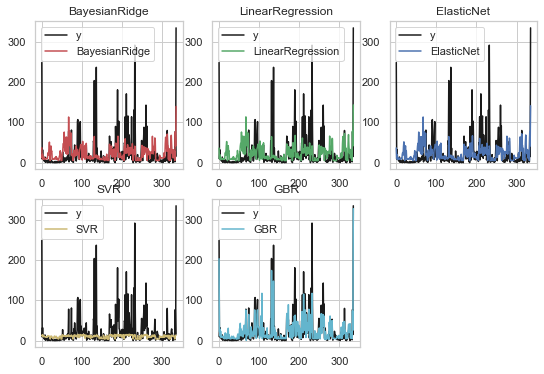

In [109]:
### 可视化 ###
# 创建画布
plt.figure(figsize=(9, 6))
# 颜色列表
color_list = ['r', 'g', 'b', 'y', 'c']
# 循环结果画图
for i, pre_y in enumerate(pre_y_list):
    # 子网络
    plt.subplot(2, 3, i+1)
    # 画出原始值的曲线
    plt.plot(np.arange(X.shape[0]), y, color='k', label='y')
    # 画出各个模型的预测线
    plt.plot(np.arange(X.shape[0]), pre_y, color_list[i], label=model_names[i])
    plt.title(model_names[i])
    plt.legend(loc='best')
plt.savefig('xxx.png')
plt.show()
